In [1]:
# Imports necessaris
import json
import os
import re
import pandas as pd
import openai

from pathlib import Path
from functools import lru_cache
from dotenv import load_dotenv
from typing import Optional, List, TypedDict
from duckduckgo_search import DDGS
from IPython.display import display, Image

from typing import TypedDict, Literal

from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_transformers import BeautifulSoupTransformer

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
# Carreguem el dataset de notícies
file_path = '../final_dataset_v2.csv'  
# Step 3: Read the CSV file
df = pd.read_csv(file_path, low_memory=False)

In [38]:
# Triar els models a comparar

# MODEL DE REFERÈNCIA
MODEL_A = "resultats_prompts_millorats"

# MODEL A COMPARAR
MODEL_B = "resultats_4_5"

In [39]:
# Creem una funció per trobar tots els articles que tenen almenys un "No" en compliment
def find_articles_with_no_compliment(data_json):
    # Dictionary to store article_id → full JSON for those with at least one "No" in compliment
    articles_with_no_dict = {}

    # Iterate through each article's analysis
    for article_id, criteria in data_json.items():
        for key, value in criteria.items():
            if isinstance(value, dict):
                if value.get("compliment", "").strip().lower() == "no":
                    articles_with_no_dict[article_id] = criteria
                    break  # Skip remaining keys for this article

    return articles_with_no_dict

# Ara una funció per comptar el nombre de criteris per cada tema
def count_criteria_by_topic(data_json):
    # Count compliments for each category across all articles
    category_counts = {}
    for article in data_json.values():
        for category, values in article.items():
            compliment = values.get("compliment", "").strip()
            if category not in category_counts:
                category_counts[category] = {"Sí": 0, "No": 0, "No aplica": 0}
            if compliment in category_counts[category]:
                category_counts[category][compliment] += 1

    # Convert the result to a DataFrame
    df_category_counts = pd.DataFrame.from_dict(category_counts, orient='index')
    df_category_counts.index.name = "Category"
    return df_category_counts

def clean_json_output(raw_output):
    # Remove triple backticks and optional "json" marker
    cleaned = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw_output.strip(), flags=re.IGNORECASE | re.MULTILINE)
    return cleaned

In [40]:
########### ANÀLISI DE RESULTATS ###########
# Comparació amb model 4_5
# Llegim els resultats del model nou
with open(f"resultats/{MODEL_B}.json", "r", encoding="utf-8") as f:
    data_nou = json.load(f)

ids = data_nou.keys()

# Llegim els resultats del model de referència
with open(f"resultats/{MODEL_A}.json", "r", encoding="utf-8") as f:
    data_4_5 = json.load(f)

# Obtenim només les claus de data_4_5 que estan també a ids
data_4_5_filtrat = {k: v for k, v in data_4_5.items() if k in ids}

# Ens assegurem que data_nou és diccionari
data_nou = {k: v for k, v in data_nou.items() if k in ids}

articles_with_no_4_5 = find_articles_with_no_compliment(data_4_5_filtrat)
articles_with_no_nou = find_articles_with_no_compliment(data_nou)

In [41]:
def find_wrong_entries(data_json):
    wrong_ids = []
    for art_id, article in data_json.items():
        if not isinstance(article, dict):
            print(f"❌ Article {art_id} is not a dict (type={type(article).__name__})")
            wrong_ids.append(art_id)
            continue

        for key, value in article.items():
            # Abans ignoraves "compliment" i "comentari", però aquests també poden ser problema
            if not isinstance(value, dict):
                print(f"❌ Article {art_id} has wrong entry in '{key}': type={type(value).__name__}, value={value}")
                wrong_ids.append(art_id)
                break  # ja hem trobat un problema en aquest article
    return wrong_ids


# Exemple d’ús
wrong = find_wrong_entries(data_nou)
print("Articles malament:", wrong)


Articles malament: []


In [42]:
# Anem a veure quins articles tenen resultats diferents
# No tenim en compte si hi ha "No aplica"
articles_with_different_results = {}
for article_id in ids:
    # Check if results differ
    if article_id in data_4_5_filtrat and article_id in data_nou:
        for key in data_4_5_filtrat[article_id]:
            if key not in data_nou[article_id]:
                continue       
            compliment1 = data_4_5_filtrat[article_id][key]['compliment']
            compliment2 = data_nou[article_id][key]['compliment']
            if compliment1 != compliment2 and compliment1 != "No aplica" and compliment2 != "No aplica":
                articles_with_different_results[article_id] = {
                    "model_referencia": data_4_5_filtrat[article_id],
                    "model_nou": data_nou[article_id]
                }

In [43]:
percentatge = round(len(articles_with_different_results) / len(data_4_5_filtrat) * 100, 2)
# Per tant
print(f"Tenim resultats diferents en un {percentatge}% dels articles entre el model de referència i el nou model.")

Tenim resultats diferents en un 48.31% dels articles entre el model de referència i el nou model.


In [44]:
topic1 = count_criteria_by_topic(data_4_5_filtrat)
topic2 = count_criteria_by_topic(data_nou)

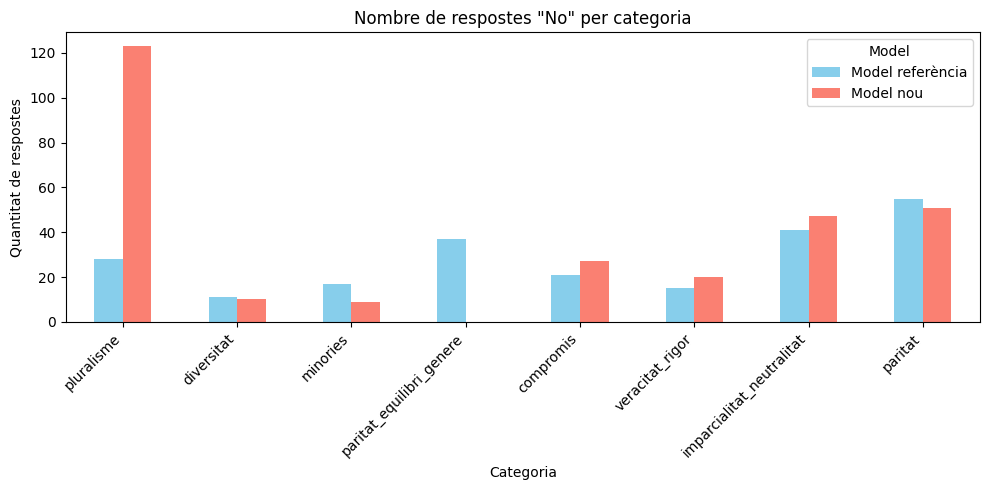

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

topic2_aligned = topic2.reindex(index=topic1.index).fillna(0)

topic1_no = topic1['No']
topic2_no = topic2_aligned['No']

# Creamos un DataFrame combinado
df_plot = pd.DataFrame({
    'Model referència': topic1_no,
    'Model nou': topic2_no
})

# Hacemos el gráfico
df_plot.plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'])

plt.title('Nombre de respostes "No" per categoria')
plt.xlabel('Categoria')
plt.ylabel('Quantitat de respostes')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [46]:
# Anem a veure-ho detalladament on hi ha diferències
from collections import Counter

# Inicialitzem el comptador
criteri_contradiccions = Counter()

for article_id in ids:
    if article_id in data_4_5_filtrat and article_id in data_nou:
        for key in data_4_5_filtrat[article_id]:
            if key not in data_nou[article_id]:
                continue
            
            compliment1 = data_4_5_filtrat[article_id][key]['compliment']
            compliment2 = data_nou[article_id][key]['compliment']

            if compliment1 != compliment2 and compliment1 != "No aplica" and compliment2 != "No aplica":
                criteri_contradiccions[key] += 1


In [47]:
# Estadístiques per criteri
# Mostrem els resultats de forma clara
nombre_noticies = len(data_4_5_filtrat)
print("\n Nombre de contradiccions per criteri (excloent 'No aplica'):\n")
for criteri, count in criteri_contradiccions.most_common():
    numero_correctes = nombre_noticies - count
    percentatge_correctes = round(numero_correctes / nombre_noticies * 100, 2)
    print(f"🔸 {criteri}: {percentatge_correctes}% correctes ({count} contradiccions)")


 Nombre de contradiccions per criteri (excloent 'No aplica'):

🔸 pluralisme: 68.26% correctes (113 contradiccions)
🔸 imparcialitat_neutralitat: 86.52% correctes (48 contradiccions)
🔸 compromis: 93.26% correctes (24 contradiccions)
🔸 veracitat_rigor: 94.1% correctes (21 contradiccions)
🔸 paritat: 96.91% correctes (11 contradiccions)
🔸 diversitat: 98.88% correctes (4 contradiccions)
🔸 minories: 98.88% correctes (4 contradiccions)


Available styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


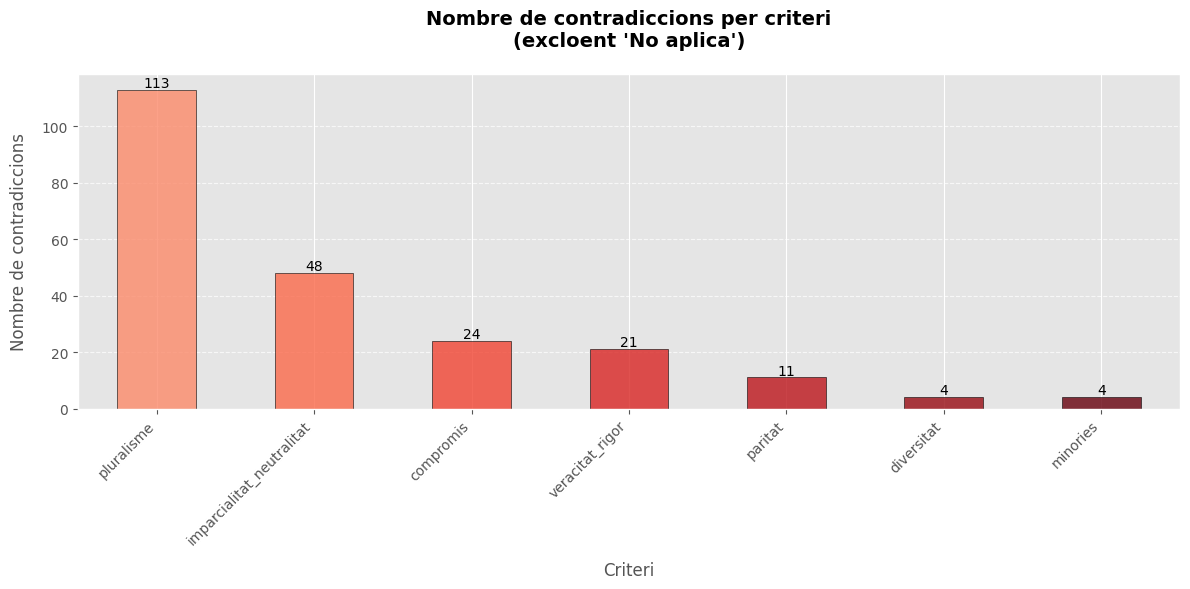

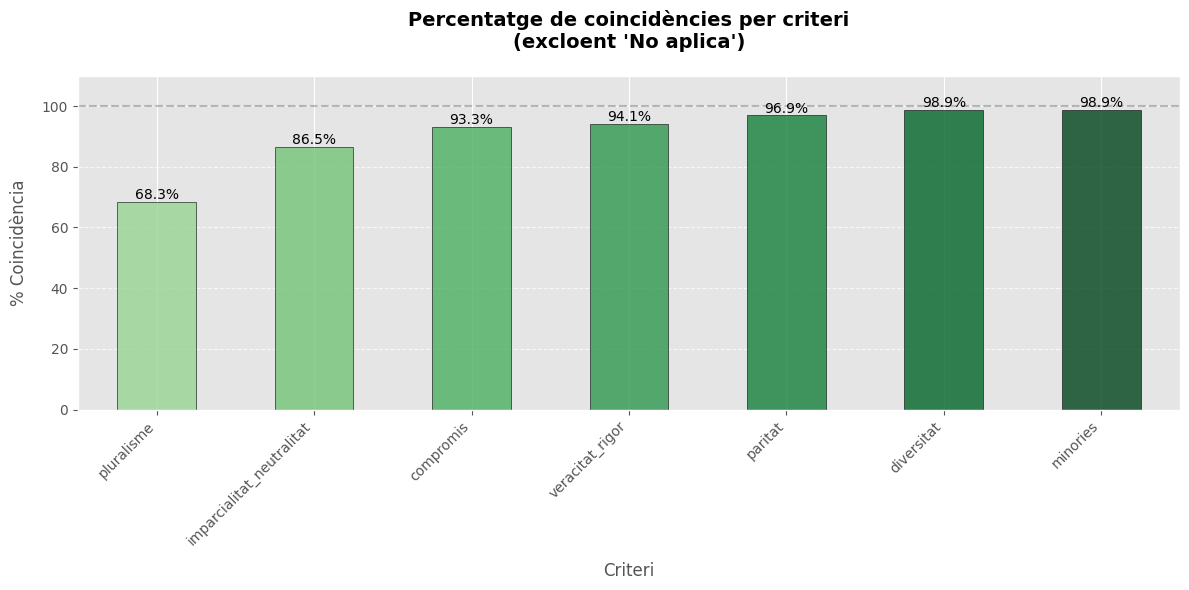

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Check available styles and use the first one that looks good
available_styles = plt.style.available
print("Available styles:", available_styles)  # This will show you what's available

# Use a modern style that exists in your environment (commonly 'ggplot', 'seaborn-v0_8', etc.)
# If 'seaborn' isn't available, try these alternatives:
plt.style.use('ggplot')  # or 'seaborn-v0_8', 'fivethirtyeight', 'tableau-colorblind10'

# Convertim el Counter a DataFrame
df_contradiccions = pd.DataFrame.from_dict(criteri_contradiccions, orient='index', columns=['Contradiccions'])
df_contradiccions['Correctes'] = nombre_noticies - df_contradiccions['Contradiccions']
df_contradiccions['% Correctes'] = (df_contradiccions['Correctes'] / nombre_noticies * 100).round(2)

# Ordenem per més contradiccions
df_contradiccions = df_contradiccions.sort_values('Contradiccions', ascending=False)

# Create a color gradient for the bars
colors_contradiccions = plt.cm.Reds(np.linspace(0.4, 1, len(df_contradiccions)))
colors_correctes = plt.cm.Greens(np.linspace(0.4, 1, len(df_contradiccions)))

# GRÀFIC 1: Nombre de contradiccions per criteri
plt.figure(figsize=(12, 6))
ax1 = df_contradiccions['Contradiccions'].plot(kind='bar', color=colors_contradiccions, edgecolor='black', alpha=0.8)
plt.title("Nombre de contradiccions per criteri\n(excloent 'No aplica')", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Criteri", fontsize=12, labelpad=10)
plt.ylabel("Nombre de contradiccions", fontsize=12, labelpad=10)

# Add value labels on top of bars
for p in ax1.patches:
    ax1.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points',
                fontsize=10)

# Improve grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# GRÀFIC 2: Percentatge de coincidències per criteri
plt.figure(figsize=(12, 6))
ax2 = df_contradiccions['% Correctes'].plot(kind='bar', color=colors_correctes, edgecolor='black', alpha=0.8)
plt.title("Percentatge de coincidències per criteri\n(excloent 'No aplica')", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Criteri", fontsize=12, labelpad=10)
plt.ylabel("% Coincidència", fontsize=12, labelpad=10)
plt.ylim(0, 110)  # Give some extra space at the top for annotations

# Add value labels on top of bars
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points',
                fontsize=10)

# Add a horizontal line at 100% for reference
plt.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

# Improve grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [49]:
# Anem a fer un anàlisi individual d'alguns articles
# Criteris que volem analitzar:
#  'pluralisme',
#  'compromis',
#  'diversitat',
#  'imparcialitat_neutralitat',
#  'independencia',
#  'minories',
#  'paritat_equilibri_genere',
#  'veracitat_rigor'

def get_articles_with_difference_in_criteria(criteri: str):
    ids_amb_diferencia = []
    
    for article_id, models in articles_with_different_results.items():
        ref_data = models['model_referencia'].get(criteri)
        nou_data = models['model_nou'].get(criteri)
        
        if not ref_data or not nou_data:
            continue
        
        val_ref = ref_data.get('compliment')
        val_nou = nou_data.get('compliment')
        
        if val_ref != val_nou and 'No aplica' not in (val_ref, val_nou):
            ids_amb_diferencia.append(article_id)
    
    return ids_amb_diferencia

In [50]:
ids = get_articles_with_difference_in_criteria('imparcialitat_neutralitat')

In [51]:
def mostrar_comparativa_criteri(criteri: str, article_id: str):
    if article_id not in articles_with_different_results:
        print(f"No hi ha resultats diferents per a l'article {article_id}.")
        return
    
    article_row = df[df['id'] == int(article_id)]
    if article_row.empty:
        print(f"No s'ha trobat l'article amb ID {article_id} al DataFrame.")
        return
    
    print(f"\n{'='*40}")
    print(f"📰 Article ID: {article_id}")
    print(f"{'-'*40}")
    print(article_row.iloc[0]['permatitle'])
    print(article_row.iloc[0]['cos'])
    print(f"{'='*40}")
    
    ref_data = articles_with_different_results[article_id]['model_referencia'].get(criteri)
    nou_data = articles_with_different_results[article_id]['model_nou'].get(criteri)
    
    if not ref_data or not nou_data:
        print(f"El criteri '{criteri}' no està disponible en un dels models.")
        return
    
    print(f"\n📊 Comparativa per criteri: {criteri.upper()}")
    print(f"{'-'*40}")
    print("Model de Referència:")
    print(f"  Compliment: {ref_data['compliment']}")
    print(f"  Comentari: {ref_data['comentari']}\n")
    
    print("Model Nou:")
    print(f"  Compliment: {nou_data['compliment']}")
    print(f"  Comentari: {nou_data['comentari']}")
    print(f"{'='*40}\n")


In [52]:
# We select random id from ids
import random
article_id = random.choice(ids)

mostrar_comparativa_criteri("imparcialitat_neutralitat", article_id)


📰 Article ID: 3291813
----------------------------------------
Manolo González: "Estic convençut: l'Espanyol pot pujar directe"
<p><strong>Visió vencedora.</strong> A les portes de les quatre últimes jornades, <strong><a href="https://www.3cat.cat/esport3/manolo-gonzalez-dos-partits-de-sancio/noticia/3287688/">Manolo González</a> ha emès un missatge optimista</strong> en una entrevista a <a href="https://www.3cat.cat/tv3/"><strong>TV3</strong></a>. El tècnic blanc-i-blau confia plenament que <strong>l'ascens directe encara és possible</strong>:</p>

<p>Per aconseguir-ho, <strong>Manolo no para de revisar la seva pissarra</strong>. Tot i mostrar bons plans de partit i bones intencions en el joc, <strong>el seu Espanyol mossega menys: tan sols set gols en vuit jornades</strong>:</p>

<p>El repte de l'ascens de l'Espanyol<strong> l'està vivint com una obsessió</strong>. L'entorn recorda que el club està <strong>a les portes del pitjor moment de la seva història</strong> o que <strong>mol